In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json
import glob
from natsort import natsorted

In [2]:
# taken from Peter and Lynne's original notebooks
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# get just the first year of observations

In [3]:
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

nside = 256
# nside = 32

# save_dir = "remove_no_template_results_{}".format(nside)
save_dir = "remove_no_template_results_{}_noDD".format(nside)
# save_dir = "/Volumes/Nargothrond/rubin_templates/remove_no_template_results_{}_noDD".format(nside)

In [4]:
opsim_fname = year1_fname
opsim_fname

'first_year_baseline_v3.0_10yrs.db'

In [5]:
# opsdb = maf.OpsimDatabase(opsim_fname)
opsdb = opsim_fname
runName = os.path.split(opsdb)[-1].replace('.db', '')
opsdb,runName

('first_year_baseline_v3.0_10yrs.db', 'first_year_baseline_v3.0_10yrs')

In [6]:
# range of nights to investigate (year 1 of survey)
night_min = 0
night_max = 365

# template generation timescales to test
# tscales = [28,28*4,28*6]
# tscales = [1,3,7,14,28,28*4,28*6]
# tscales = [3,7,14,28,28*4,28*6]
tscales = [28]

# store the timescale and template generation nights in a dict
template_timescales = {}

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,night_max+tscale,tscale)
    template_nights[-1] = night_max # consider only the first year
        
    template_timescales[str(tscale)] = template_nights
    
template_timescales

{'28': array([  0,  28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336,
        364, 365])}

In [7]:
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

# Load the saved template metric data and combine the chunks

In [15]:
def load_template_metric(runName,
                         metric="doAllTemplateMetrics_Count",
                         slicer = "HEAL",
                         filt="all",save_dir="remove_no_template_results_32",
                         time = False,
                         operation="sum",
                        print_flag=False):
    
    """
    The doAllTemplateMetrics works by running metrics on batches of observations made between nights on which templates were generated.
    This function loads the all the files of a previously run metric.
    An operation can be performed on all of these reloaded metrics,
    e.g. the total number of visits from the "Count" metric can be found by using "sum".
    
    time allows you to select a single metric file for some time batch
    
    The save_dir is searched for files matching some pattern: runName, metric, filt, slicer
    """
        
    # glob all files in the save_dir
    files = glob.glob("{}/*npz".format(save_dir))
    
    # select the relevant metric files using the patterns
    if filt=="all": # select all filters
        _files = [x for x in files if (runName in x) 
                 & (metric in x)
                 & (slicer in x)
                 & ~(("_u_".format(filt) in x)
                 | ("_g_".format(filt) in x)
                 | ("_r_".format(filt) in x)
                 | ("_i_".format(filt) in x)
                 | ("_z_".format(filt) in x)
                 | ("_y_".format(filt) in x))
                 ]
    elif "_or_" in filt:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)
                  & ("_or_" in x)]
    else:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)
                  & ("_or_" not in x)]
            
    if time: # trim down based on a specific timestamp
        _files = [x for x in _files if ("_lt_{}_".format(str(time)) in x)]        
        
    _files = natsorted(_files) # ensure files are in numerical order (based on the template generation night considered)
    if print_flag:
        print(_files)
    print(len(_files))
    
    if len(_files)==0:
        # there are no files
        print("no files")
        return

    # load all these metric files
    metric_bundle = []
    for x in _files:
        metric_bundle.append(maf.MetricBundle.load(x))

    # retrieve data/mask for all the masked arrays
    # each value in data corresponds to the metric value for some slice point
    data = [mb.metric_values.data for mb in metric_bundle]
    mask = [mb.metric_values.mask for mb in metric_bundle]
    metric_data = np.ma.array(data, mask=mask)

    if operation == "min":
        # find the minimum of all constituent metrics
        metric_vals = metric_data.min(axis=0)
    elif operation == "sum":
        # find the sum of all constituent metrics
        ### Sum of just one file should produce just the file?
        metric_vals = metric_data.sum(axis=0)
    ### Add a new operation for DeltaNight and NTemplate
#     elif operation == "first":
#         # take the first not badval value
    else:
        # return the untouched multidimensional masked array if you want to look at it separately
        print("no operation performed")
        metric_vals = metric_data
    
    print(metric_vals,len(metric_vals))
    
    # replace the masked values with nan
    metric_vals.fill_value = np.nan
    
    return metric_vals

In [16]:
def skymap_plot_Night(metric_plot, title, 
                      template_nights,
                      _min=None, _max=None):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    min = _min, max=_max,
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

#     # fix the ticks at 0 nights and at the end?
#     ticks = template_nights[:-1]
#     cbar.set_ticks(ticks)
#     cbar.set_ticklabels(ticks)
    
    # set vmin, vmax to get constant scale for comparision?

#     fname = "{}.png".format("".join(title.split(" ")))
#     plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")
    
    plt.show()

In [17]:
# load individual template dates
# count the number of unique visits with templates

In [18]:
def skymap_plot(metric_plot, title):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

#     fname = "{}.png".format("".join(title.split(" ")))
#     plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

    plt.show()

In [19]:
def histogram_plot(metric_plot,bins="auto",title="hist_plot",pix_area=None):
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

    # ax1.axvline(np.median(data),c="C{}".format(i))

    # total area
    print(sum(n)*pix_area)

    
    ### CONVERT UNITS OR SCALE AXIS?
    if pix_area:
        # scale the y axis to get sky area
        y_vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])
        ax1.set_ylabel("area (square degrees)")
    else:
        ax1.set_ylabel("number of healpixels")

    ax1.set_xlabel("metric number")

    plt.title("{} {}".format(_runName,m))

    plt.show()

In [20]:
# plot the results of the default baseline simulation

### TODO
# MAKE SURE AN OPERATION IS NOT PERFORMED HERE
# if len(_files)==1 return just the metric?
# Could be fine as the sum over a len 1 array is unchanged

# for m in ["CountMetric","PairMetric"]:
#     filt = "all"
#     pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

#     _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
#     print(_runName,m,filt)
#     metric_plot = load_template_metric(_runName,
#                                        metric=m,
#                                        filt=filt, print_flag=True,
#                                       save_dir = save_dir)
#     print(metric_plot.shape)

#     title = "{} {}".format(_runName,m)
#     skymap_plot(metric_plot, title = title)
#     histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

first_year_baseline_v3_0_10yrs_nside-256 CountMetric all
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 22.0 27.0 24.0] 786432
(786432,)


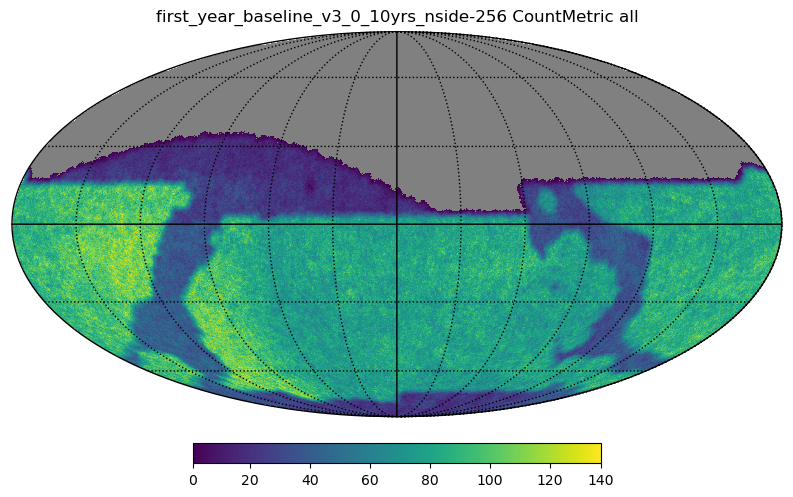

28006.651926315553


/tmp/ipykernel_3473616/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


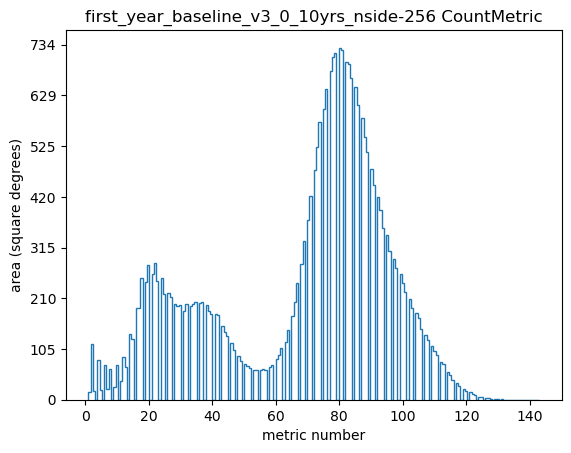

first_year_baseline_v3_0_10yrs_nside-256 CountMetric u
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- 1.0] 786432
(786432,)


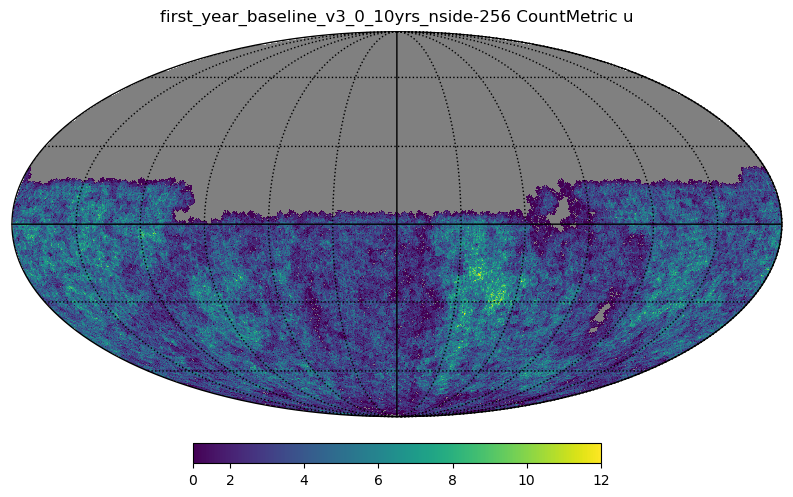

24415.15705089849


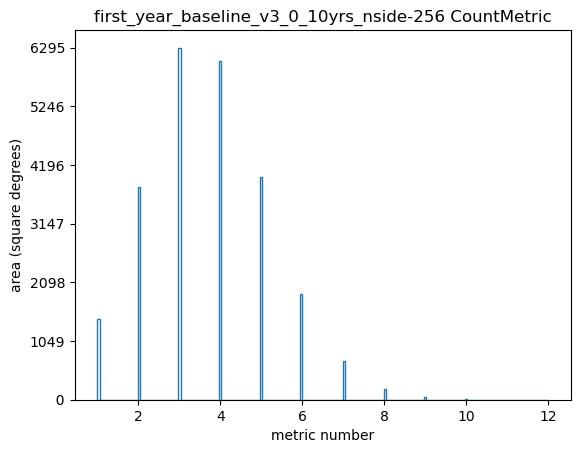

first_year_baseline_v3_0_10yrs_nside-256 CountMetric g
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- 1.0] 786432
(786432,)


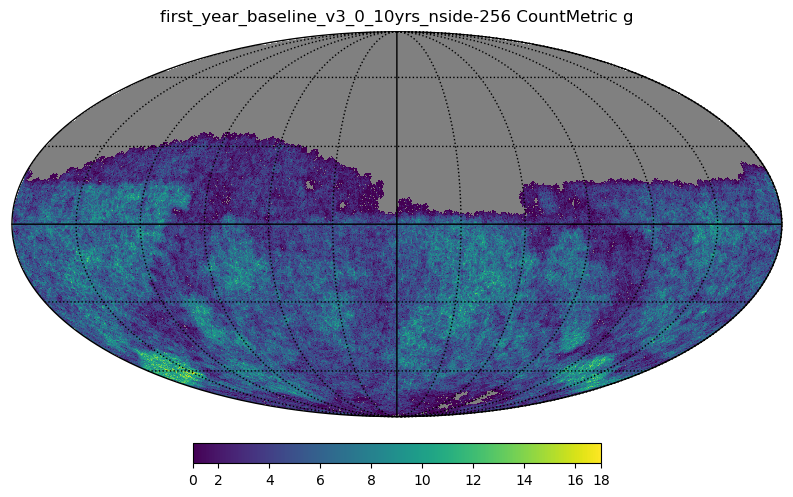

27514.353747546378


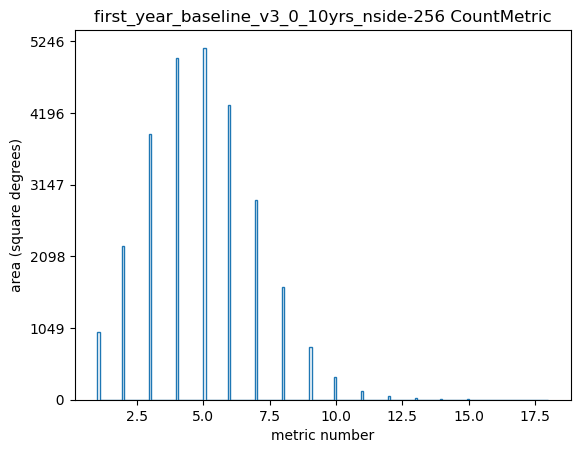

first_year_baseline_v3_0_10yrs_nside-256 CountMetric r
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 2.0 3.0 2.0] 786432
(786432,)


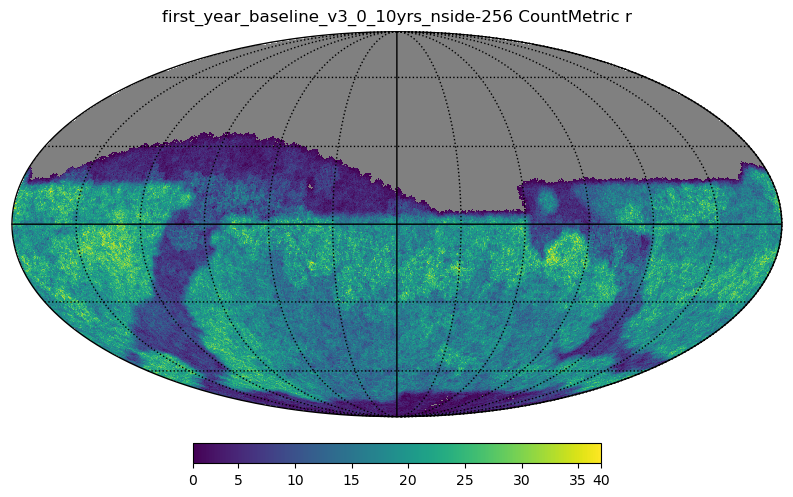

27892.82272568379


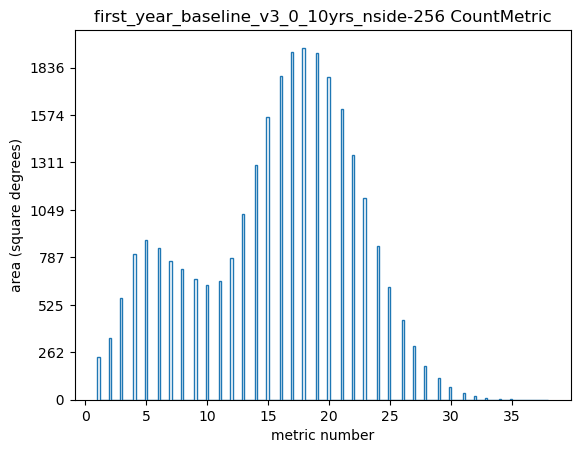

first_year_baseline_v3_0_10yrs_nside-256 CountMetric i
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 7.0 10.0 8.0] 786432
(786432,)


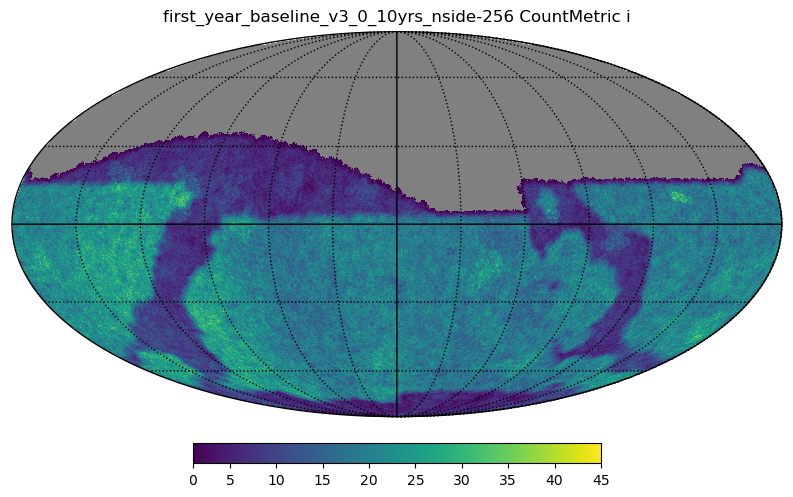

27938.87896446475


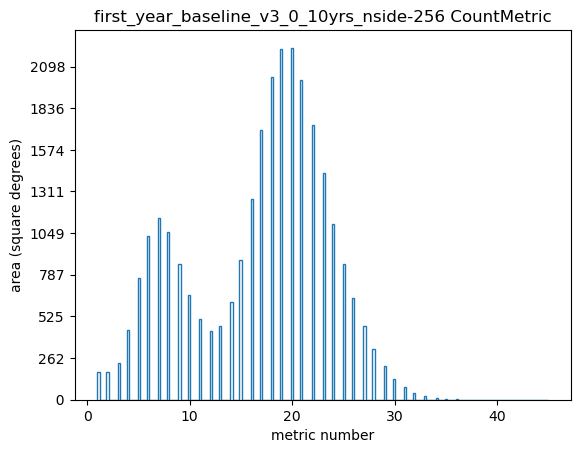

first_year_baseline_v3_0_10yrs_nside-256 CountMetric z
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 7.0 7.0 7.0] 786432
(786432,)


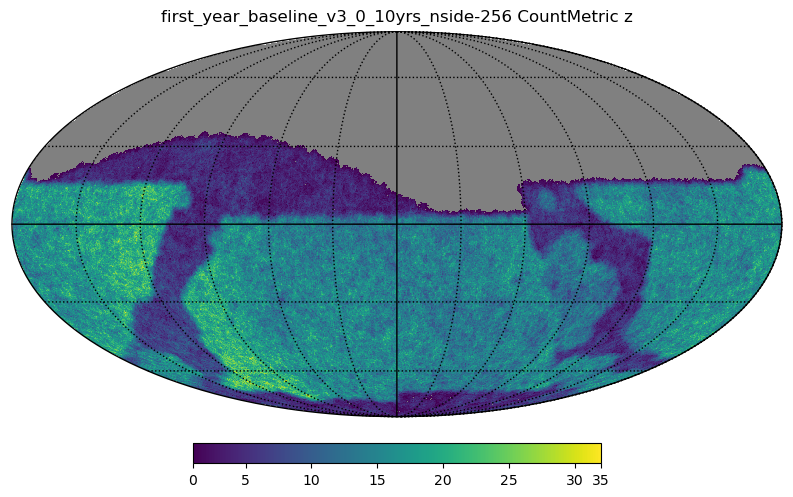

27856.680643086882


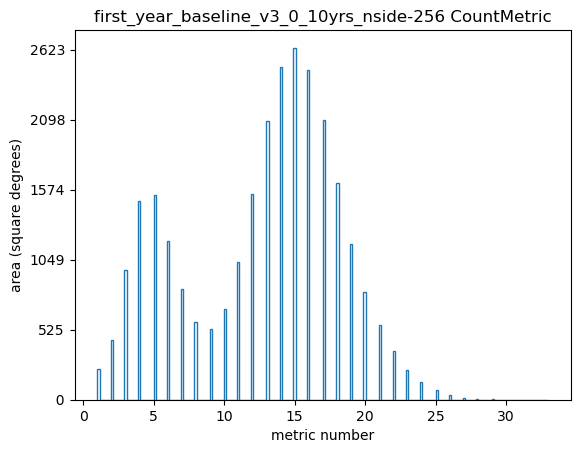

first_year_baseline_v3_0_10yrs_nside-256 CountMetric y
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 6.0 7.0 5.0] 786432
(786432,)


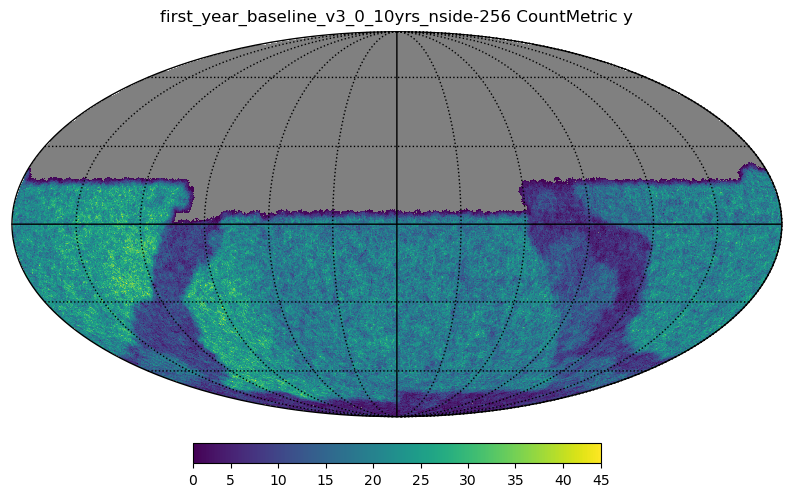

24905.304539701814


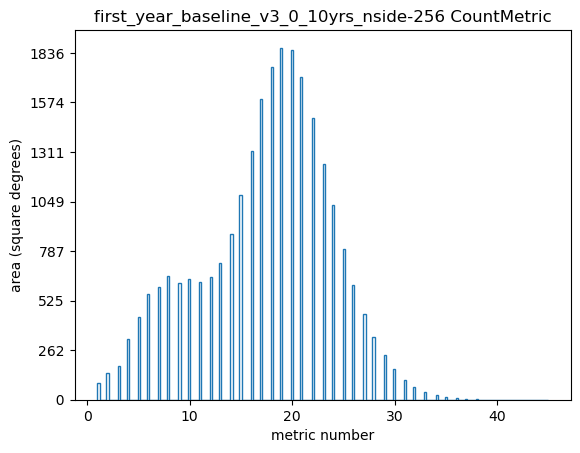

In [21]:
m = "CountMetric"

for filt in ["all","u","g","r","i","z","y"]:
    
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {} {}".format(_runName,m,filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

first_year_baseline_v3_0_10yrs_nside-256 PairMetric all
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_PairMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 8.0 9.0 8.0] 786432
(786432,)


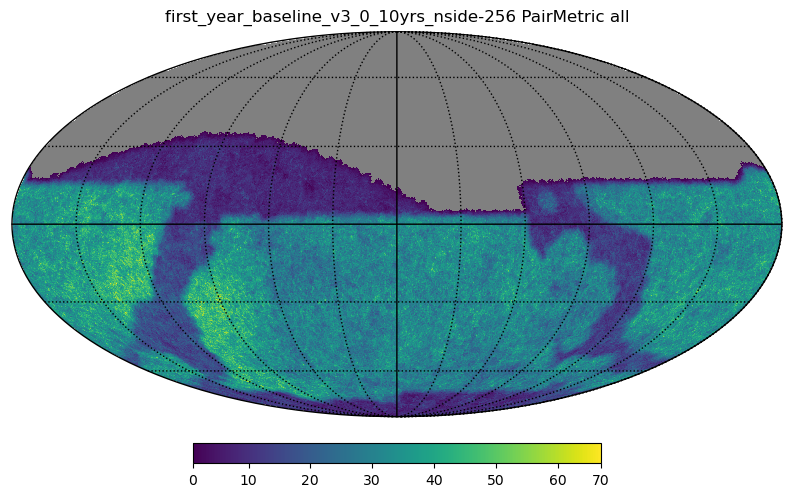

27972.135975156245


/tmp/ipykernel_3473616/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


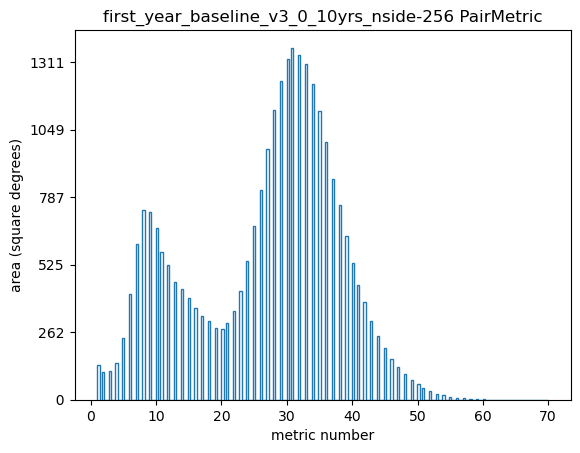

first_year_baseline_v3_0_10yrs_nside-256 PairMetric r_or_g
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_PairMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)


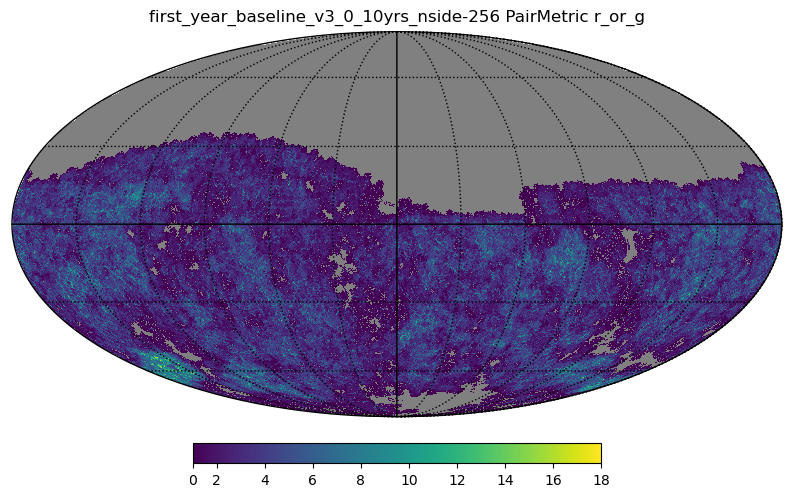

26336.09038137555


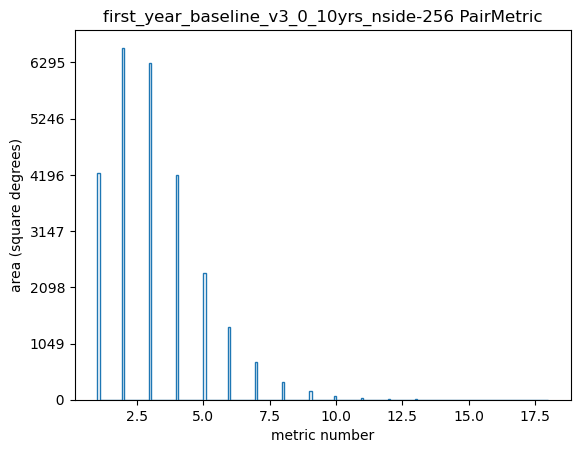

first_year_baseline_v3_0_10yrs_nside-256 PairMetric r_or_i
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_PairMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 2.0 3.0 1.0] 786432
(786432,)


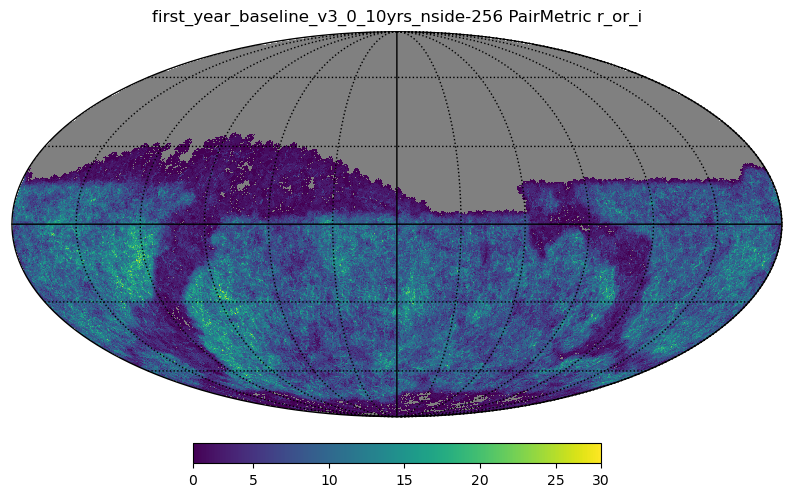

27387.62040711949


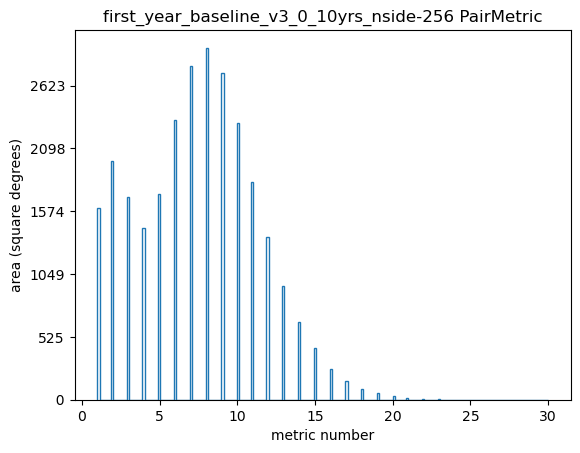

first_year_baseline_v3_0_10yrs_nside-256 PairMetric r_or_z
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_PairMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)


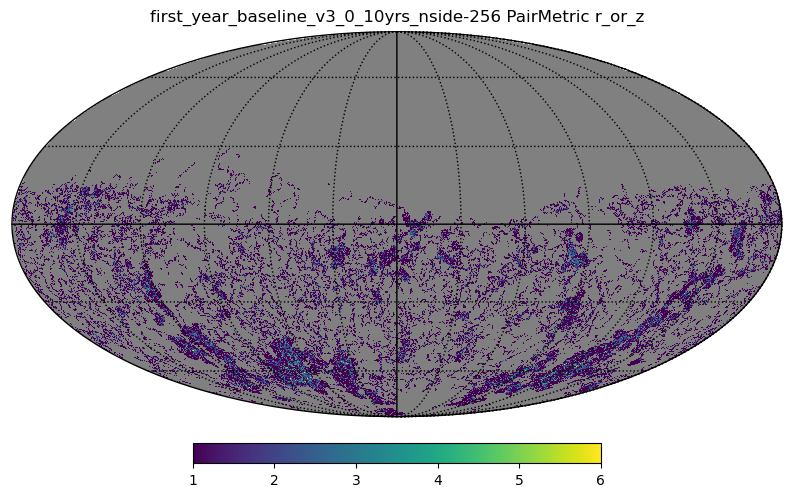

6860.648535220206


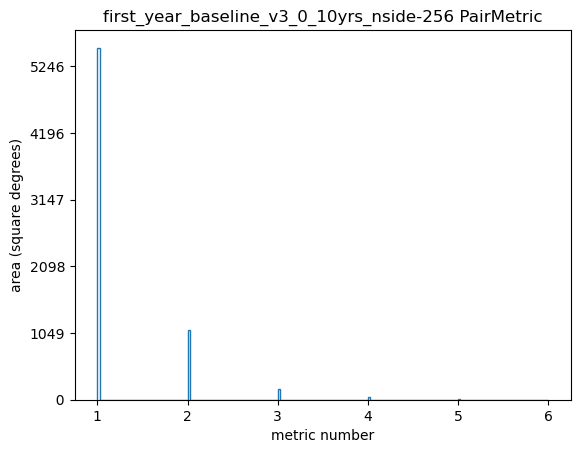

In [22]:
m = "PairMetric"

for filt in ["all","r_or_g","r_or_i","r_or_z"]:
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {} {}".format(_runName,m,filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

In [23]:
### TODO
# double check the area in the pair histogram

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight r
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer

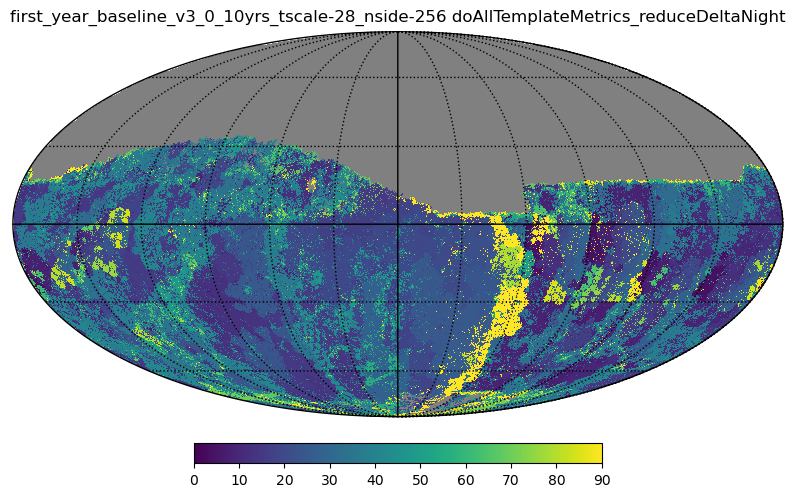

27297.815987081896


/tmp/ipykernel_3473616/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


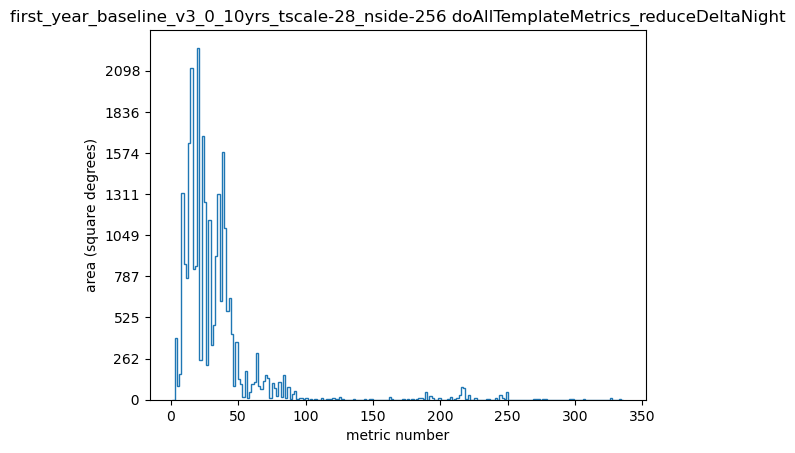

In [25]:
# m = "doAllTemplateMetrics_Night"
m = "doAllTemplateMetrics_reduceDeltaNight" # add a vline at the template timescale to see if it peaks
filt = "r"

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,365+tscale,tscale)
    template_nights[-1] = 365 # consider only the first year
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,
                                       operation="min",save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    
#     skymap_plot_Night(metric_plot, title = title, template_nights = template_nights,
#                       _min = 0, _max = 365)
    skymap_plot_Night(metric_plot, title = title, template_nights = template_nights,
                      _min = 0, _max = 90)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
    
#     break

In [26]:
metric_plot

masked_array(data=[--, --, --, ..., --, 126.0, --],
             mask=[ True,  True,  True, ...,  True, False,  True],
       fill_value=nan)

In [28]:
m = "doPairTemplateMetrics_reducePairs"
filt = "all"
# filt = "r_or_g"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins=200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doPairTemplateMetrics_reducePairs all
0
no files


AttributeError: 'NoneType' object has no attribute 'shape'

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount all
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer us

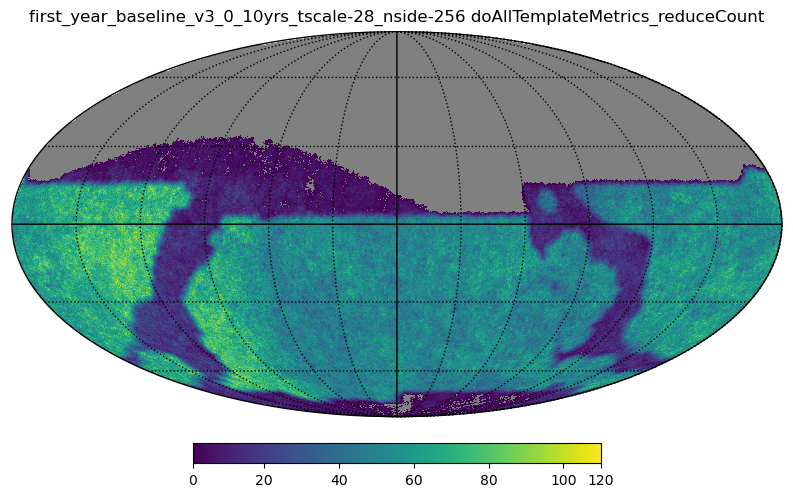

27340.56750713484


/tmp/ipykernel_3473616/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


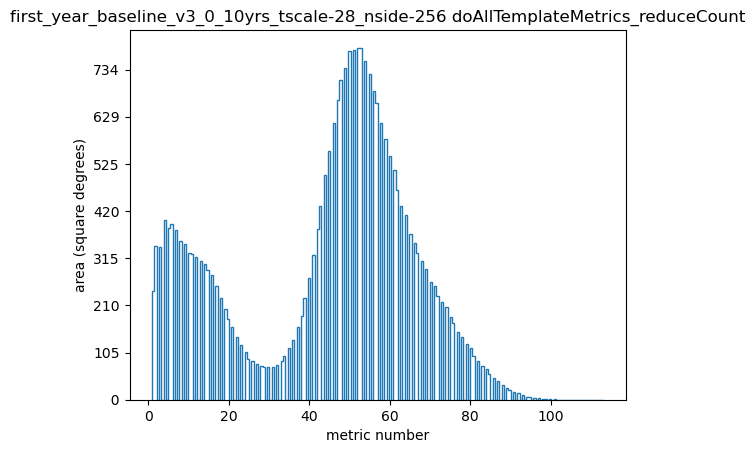

In [29]:
m = "doAllTemplateMetrics_reduceCount"
filt = "all"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer usin

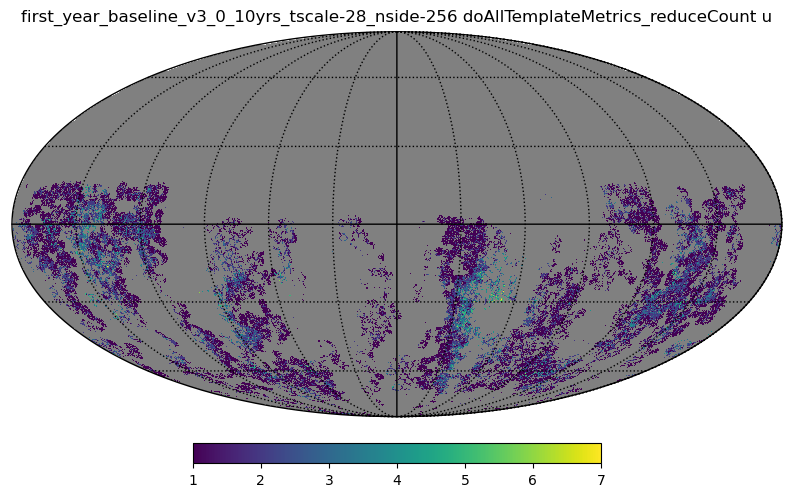

6386.500081528722


/tmp/ipykernel_3473616/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


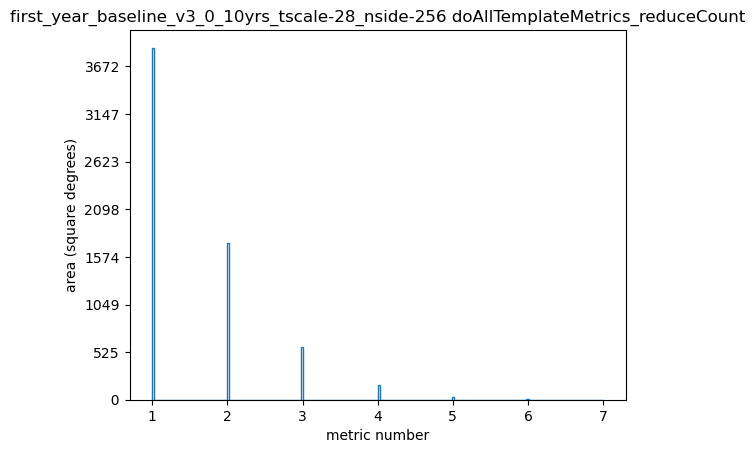

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer usin

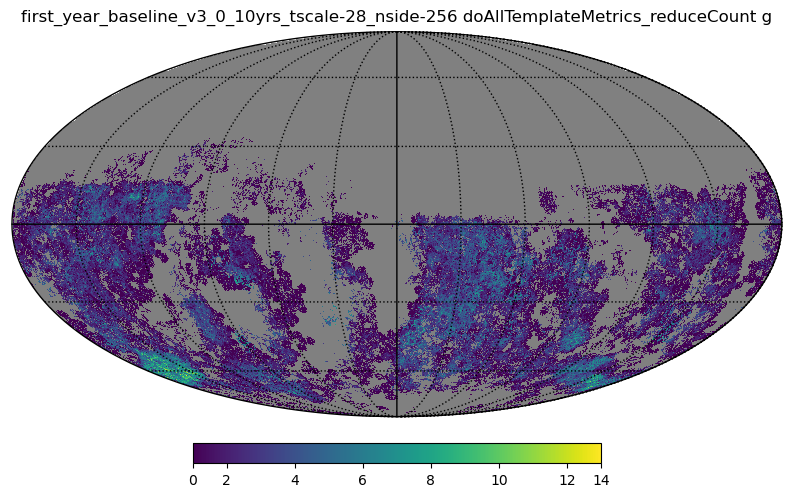

14630.829102585189


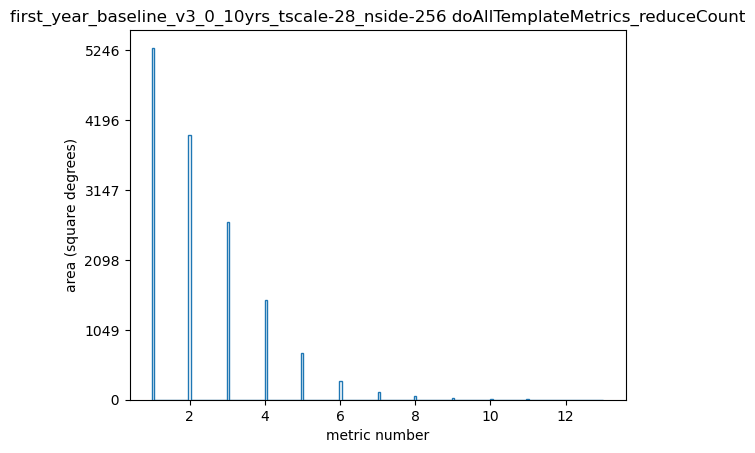

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount r
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer usin

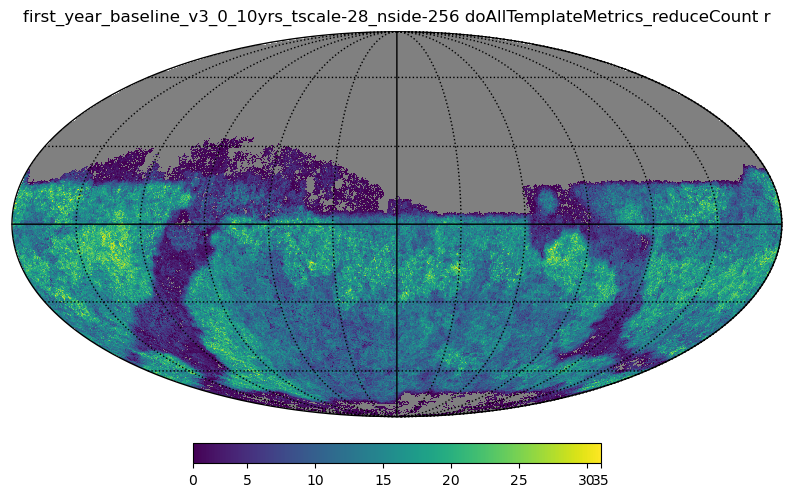

26154.43576304016


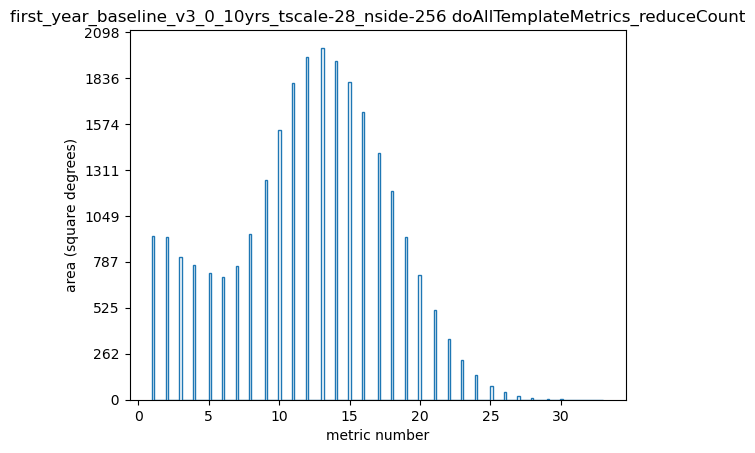

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer usin

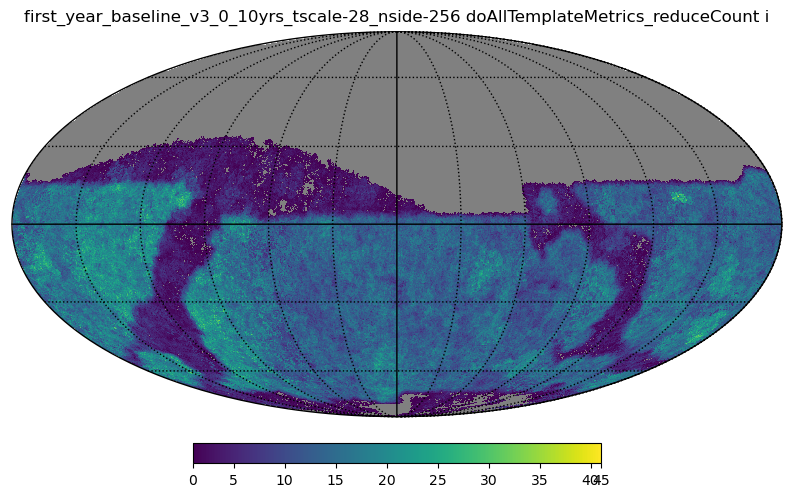

26975.002668792553


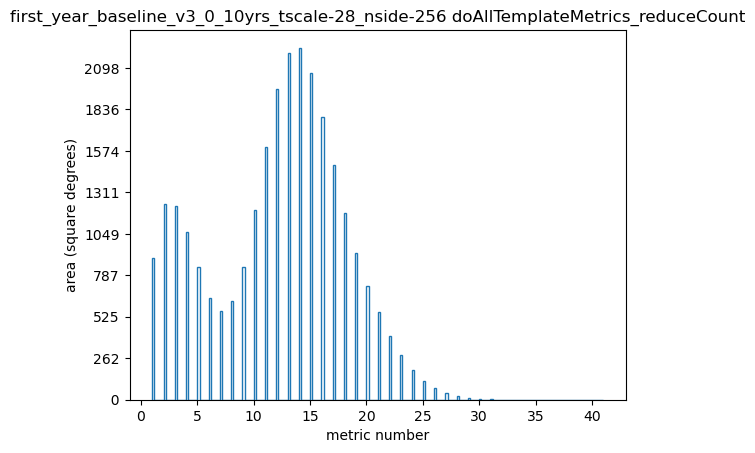

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount z
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer usin

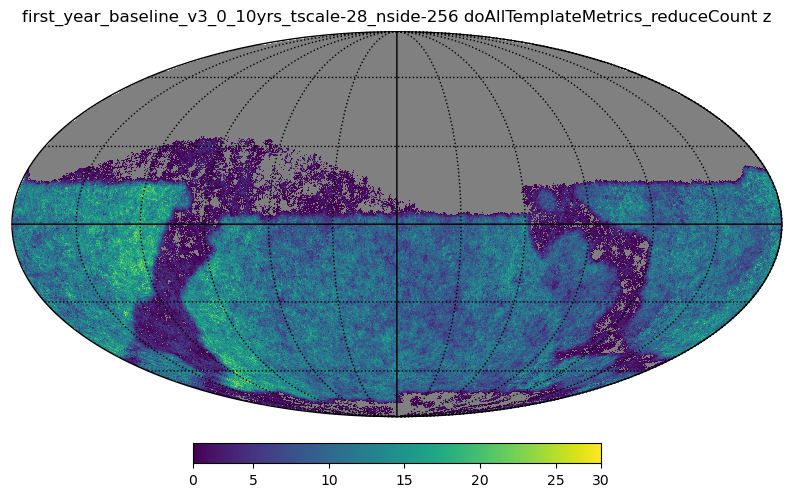

25390.573634192348


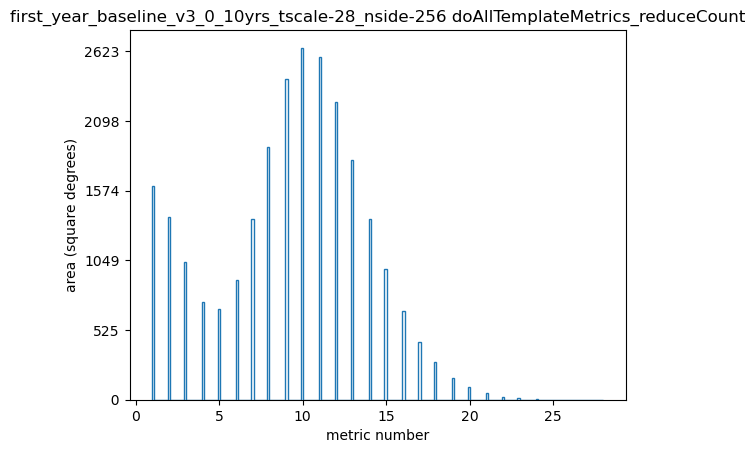

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y
13
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer usin

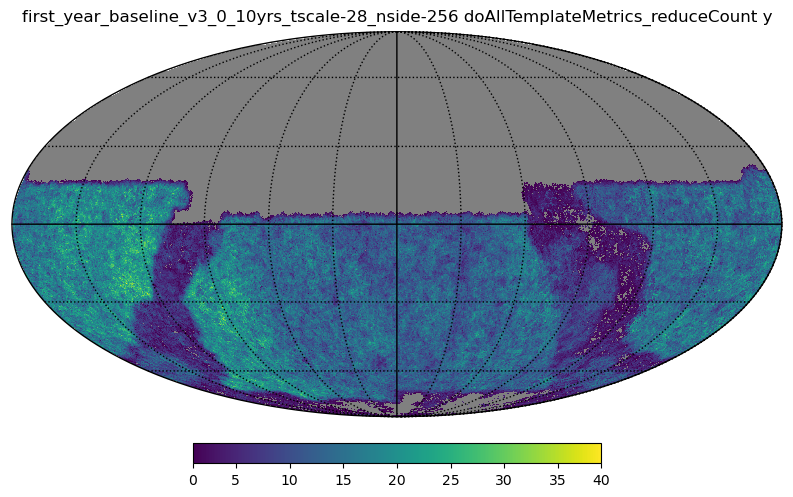

23967.918449706594


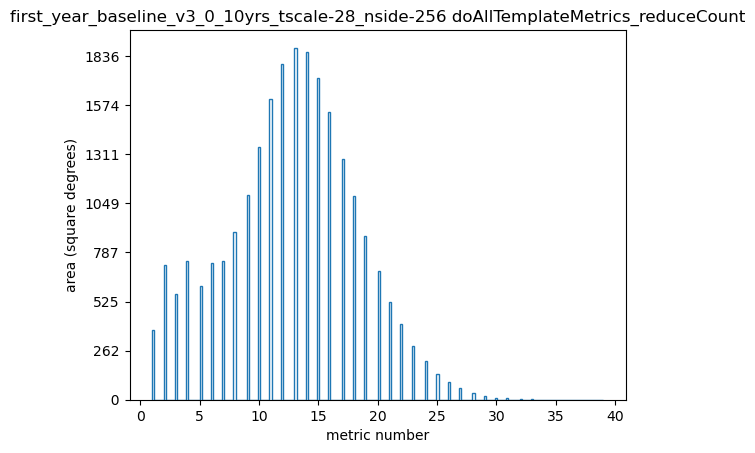

In [30]:
m = "doAllTemplateMetrics_reduceCount"
filters = ["u","g","r","i","z","y"]
tscale = 28
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for filt in filters:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {} {}".format(_runName,m, filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        

In [31]:
# Count up area in footprint from the baseline, for reference (varies by filter)
m = "CountMetric"
_runName = "{}_nside-{}".format(runName,nside).replace(".","_")
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

footprint_area = {}
for filt in 'ugrizy':
    
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)
    
    x = metric_plot.data
    
    footprint_area[filt] = len(x[x>0]) * pix_area    

first_year_baseline_v3_0_10yrs_nside-256 CountMetric u
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- 1.0] 786432
(786432,)
first_year_baseline_v3_0_10yrs_nside-256 CountMetric g
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- 1.0] 786432
(786432,)
first_year_baseline_v3_0_10yrs_nside-256 CountMetric r
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 2.0 3.0 2.0] 786432
(786432,)
first_year_baseline_v3_0_10yrs_nside-256 CountM

In [32]:
footprint_area

{'u': 24415.15705089849,
 'g': 27514.353747546378,
 'r': 27892.82272568379,
 'i': 27938.87896446475,
 'z': 27856.680643086882,
 'y': 24905.304539701814}

In [33]:
m = "doAllTemplateMetrics_reduceCount"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

area_Count = {}

for tscale in tscales:
    
    template_nights = template_timescales[str(tscale)]
    print(template_nights)
    
    area_Count[str(tscale)] = {}
    
    for filt in 'ugrizy':
#     for filt in 'grizy':
        
        visit_area = []

        for t in template_nights[1:]:
        
            _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
            print(runName,m,filt, t)
            metric_plot = load_template_metric(_runName,
                                               metric=m,
                                               filt=filt,
                                               time = t,
                                               save_dir = save_dir,
                                              print_flag = True)
            
            # there may be missing metric files (e.g. no observations of u with t<7d)
            if metric_plot is None:
                visit_area.append(0)
                continue
                
            print(metric_plot.shape)
            
            x = metric_plot.data
            area = len(x[x>0]) * pix_area
            
            visit_area.append(area)
            print(area)    
            
        visit_area = np.array(visit_area)
        
        area_Count[str(tscale)][filt] = visit_area
#         break


[  0  28  56  84 112 140 168 196 224 252 280 308 336 364 365]
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u 28
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_u_and_night_lt_28_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u 56
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_u_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
41.702402996429846
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount u 84
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_u_an

[-- -- -- ... -- -- --] 786432
(786432,)
1120.0898253871278
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g 280
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_g_and_night_lt_280_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
1587.9960325923532
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g 308
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_g_and_night_lt_308_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
1233.971481871718
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount g 336
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics

[-- -- -- ... -- 1.0 1.0] 786432
(786432,)
9641.385749363279
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i 168
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_i_and_night_lt_168_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 1.0 1.0 1.0] 786432
(786432,)
9897.842413828115
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i 196
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_i_and_night_lt_196_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... 1.0 3.0 1.0] 786432
(786432,)
10896.601851629404
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount i 224
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplate

[-- -- -- ... -- -- --] 786432
(786432,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y 56
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_y_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
6212.294194294579
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y 84
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_y_and_night_lt_84_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
7768.029877399128
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceCount y 112
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceCount_y_and_n

In [34]:
### u filter failing for 7d timescale? Missing a file?
# There are no u observations with t<7d
### Add a missing metric file exception

28 u 0.2768508213697948
28 g 0.7369405403756548
28 r 3.9359159286792957
28 i 4.187838540639897
28 z 3.6496469259015165
28 y 4.076784066926995


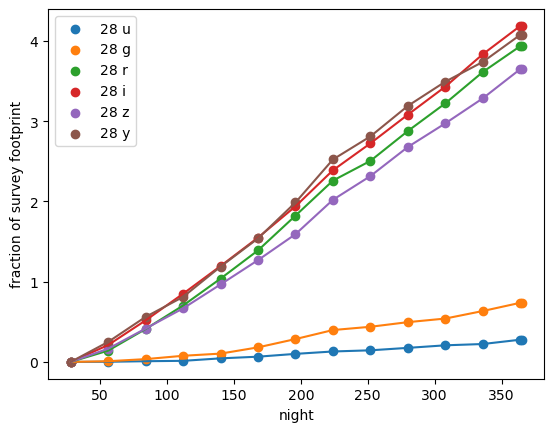

In [35]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])


for tscale in [28]:
    
    template_nights = template_timescales[str(tscale)]
        
    for filt in 'ugrizy':
#     for filt in 'grizy':
        
        visit_area = area_Count[str(tscale)][filt]
        
        cum_visit_area = visit_area.cumsum()
        
        ax1.plot(template_nights[1:],cum_visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],cum_visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))
        
        print(tscale,filt,cum_visit_area[-1]/footprint_area[filt])

ax1.set_xlabel("night")
ax1.set_ylabel("fraction of survey footprint")

ax1.legend()

plt.show()

In [ ]:
m = "doAllTemplateMetrics_reduceDeltaNight"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

area_DeltaNight = {}

for tscale in tscales:
    
    template_nights = template_timescales[str(tscale)]
    print(template_nights)
    
    area_DeltaNight[str(tscale)] = {}
    
    for filt in 'ugrizy':
        
        visit_area = []

        for t in template_nights[1:]:
        
            _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
            print(runName,m,filt, t)
            metric_plot = load_template_metric(_runName,
                                               metric=m,
                                               filt=filt,
                                               time = t,
                                               save_dir = save_dir,
                                              print_flag = True)
            
            if metric_plot is None:
                visit_area.append(0)
                continue
                
            print(metric_plot.shape)
            
            x = metric_plot.data
            area = len(x[x>0]) * pix_area
            
            visit_area.append(area)
            print(area)    
            
        visit_area = np.array(visit_area)
        
        area_DeltaNight[str(tscale)][filt] = visit_area
#         break

### This is probably not correct...
# instead just load DeltaNight for all year 1 with minimum operation
# i.e. convert year 1 DeltaNight histogram to a cumulative dist


[  0  28  56  84 112 140 168 196 224 252 280 308 336 364 365]
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight u 28
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceDeltaNight_u_and_night_lt_28_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight u 56
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplateMetrics_reduceDeltaNight_u_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
[-- -- -- ... -- -- --] 786432
(786432,)
1198.4064136558948
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_reduceDeltaNight u 84
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-256_doAllTemplat

In [ ]:
area_DeltaNight["28"]

In [ ]:
template_nights, len(template_nights)

In [ ]:
visit_area, len(visit_area)

In [ ]:
visit_area.cumsum(), len(visit_area.cumsum())

In [ ]:
for tscale in tscales:

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    template_nights = template_timescales[str(tscale)]

    for filt in 'ugrizy':

        visit_area = area_DeltaNight[str(tscale)][filt]

        ax1.plot(template_nights[1:],visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))

        print(tscale,filt,visit_area[-1]/footprint_area[filt])

    ax1.set_xlabel("DeltaNight")
    ax1.set_ylabel("fraction of survey footprint")

    ax1.legend()
    plt.title(tscale)

    plt.show()

In [ ]:
# the stepped pattern emerges as a result of the template cadence and general survey cadence
# What is the typical revisit timescale of the baseline?
# note that the 28 d timescale, u filter last jump up is due to a very short last time period to get up to 365 d

In [ ]:
### need a "first" operation when loading
### check these plots, why does Count need to be cumulative but DeltaNight is regular?
### Why does our z differ so much to Lynne's?

In [ ]:
for filt in "ugrizy":
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    for tscale in tscales:

        template_nights = template_timescales[str(tscale)]

        visit_area = area_DeltaNight[str(tscale)][filt]

        ax1.plot(template_nights[1:],visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))

        print(tscale,filt,visit_area[-1]/footprint_area[filt])

    ax1.set_xlabel("DeltaNight")
    ax1.set_ylabel("fraction of survey footprint")

    ax1.legend()
    
    plt.title(filt)
    
    ax1.set_ylim(0,1)
    ax1.set_xlim(0,90)

    plt.show()

In [ ]:
filt = "u"
tscale = 28
visit_area = area_DeltaNight[str(tscale)][filt]
visit_area/footprint_area[filt]